# Step-by-Step Diffusion

Pedagogical implementations following Nakkiran et al. [Step-by-Step Diffusion: An Elementary Tutorial](https://arxiv.org/abs/2406.08929)

# Setup

In [ ]:
import numpy as np
import torch.nn as nn

In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device found. Using Apple Silicon GPU.")
else:
    device = torch.device("cpu")
    print("MPS device not found. Using CPU.")

# Gaussian Diffusion

The Gaussian Diffusion forward process is initially defined as
$$ x_{t+1} := x_t + η_t \ , \ η_t \sim N (0, σ^2). $$

In [ ]:
class SimpleGaussianDiffusion:
    def __init__(self, num_timesteps, sigma_q):
        self.num_timesteps = num_timesteps
        self.sigma_q = sigma_q
        self.delta_t = 1.0 / num_timesteps

    def forward_process(self, x0, return_trajectories=False):
        """
        Implements the forward process x_{t+Δt} := x_t + η_t, η_t ~ N(0, σ_q^2 Δt)
        from equation 11 on page 7 of the tutorial
        """
        print(f"self num timesteps {self.num_timesteps}")
        xt = x0
        if return_trajectories:
            trajectories = [x0]
        for t in range(self.num_timesteps):
            eta = torch.randn_like(xt) * self.sigma_q * torch.sqrt(torch.tensor(self.delta_t))
            xt = xt + eta
            if return_trajectories: trajectories.append(xt)
        if return_trajectories: return torch.stack(trajectories)
        return xt

    def sample_xt(self, x0, t):
        """
        Samples x_t ~ N(x_0, σ_t^2), where σ_t := σ_q√t
        """
        sigma_t = self.sigma_q * torch.sqrt(torch.tensor(t * self.delta_t))
        noise = torch.randn_like(x0) * sigma_t
        return x0 + noise

## Visualization

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def visualize_diffusion(x0, diffusion, num_frames=50):
    trajectories = diffusion.forward_process(x0, return_trajectories=True)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_aspect('equal', adjustable='box')
    
    scatter = ax.scatter([], [], alpha=0.6)
    title = ax.set_title(f'Timestep: 0/{diffusion.num_timesteps}')
    
    def update(frame):
        i = int(frame * diffusion.num_timesteps / num_frames)
        data = trajectories[i].tolist()
        scatter.set_offsets(data)
        title.set_text(f'Timestep: {i}/{diffusion.num_timesteps}')
        return scatter, title

    anim = FuncAnimation(fig, update, frames=num_frames, interval=50, blit=True)
    plt.close(fig)
    return anim

In [ ]:
num_timesteps = 1000
sigma_q = 1.0
diffusion = SimpleGaussianDiffusion(num_timesteps, sigma_q)

# generate points on a circle
theta = torch.linspace(0, 2*torch.pi, 100)
x0 = torch.stack([torch.cos(theta), torch.sin(theta)], dim=1)

anim = visualize_diffusion(x0, diffusion)
from IPython.display import HTML
HTML(anim.to_jshtml())

# DDPM-Like Reverse Sampler

We'll start with the presentation of the Diffusion Reverse process in Section 1.3, then work towards DDPM. __Fact 1__ tells us that for a small variance $\sigma$ and the Gaussian diffusion process from (1), the conditional distribution $p(x_{t-1} \ | \ x_t)$ is itself Gaussian. This means, given a fixed value for $x_t$ at some timestep, there is some mean parameter $\mu \in \mathbb{R}^d$ s.t. $$ p(x_{t-1} \ | \ x_t) \approx \mathcal{N}(x_{t-1}; \ \mu \ , \ \sigma^2) $$

Since we know everything about the distribution except its mean, we need only learn the mean $\mu_{t-1}(x_t)$ to learn the full conditional distribution; we can learn this by regression. 

Using a fact about conditional expectation, we can turn the estimate of the conditional expectations $$ \mu_t(z) := \mathbb{E} \left[ x_t \ | \ x_{t + \Delta t} = z \right] $$ into a standard regression problem. In particular, to learn the set of functions $\mu_t$ for every timestep $t \in {0,\Delta t,..., 1 - \Delta t}$ in a _training_ phase, we estimate the functions from i.i.d. samples of $x_0$ by optimizing the denoising regression objective 
$$ \mu_t = \underset{f : \mathbb{R}^d \rightarrow \mathbb{R}^d }{\text{argmin}} \underset{{x_t, x_{t + \Delta t}}}{\mathbb{E}} || f(x_{t+ \Delta t}) - x_t ||_2^2 $$
with a neural network parameterizing $f$. In the inference phase, we use estimated functions in the following DDPM-like Stochastic Reverse Sampler:


__Algorithm 1__: \
For input sample $x_t$ and timestep $t$, output:
$$ \hat{x}_{t - \Delta t} \leftarrow \mu_{t - \Delta t}(x_t) + \mathcal{N}(0, \sigma_q^2\Delta t) $$

We'll use a basic model (UNet) for reverse sampling. 

## Base Class

In [ ]:
class DDPM(nn.Module):
    def __init__(self, num_timesteps, beta_start=1e-4, beta_end=0.02):
        super().__init__()
        self.num_timesteps = num_timesteps
        self.beta = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.sigma_q = torch.sqrt(self.beta)

    def forward(self, x, t):
        pass

In [ ]:
class BaseUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, out_channels, 3, padding=1)
        
    def forward(self, x, t):
        # t is a float between 0 and 1
        t = t.view(-1, 1, 1, 1).expand(-1, 1, x.shape[2], x.shape[3])
        x = torch.cat([x, t], dim=1)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        return self.conv3(x)

## DDPM Train Loss

Following Pseudocode 1 (Section 2.2) to implement DDPM train loss:

In [ ]:
def ddpm_train_loss(model, x0, num_timesteps, sigma_q):
    device = next(model.parameters()).device
    # Sample t uniformly from {0, delta_t, 2*delta_t, ..., (T-1)*delta_t}
    t = torch.randint(0, num_timesteps, (x0.shape[0],), device=device)

    # generate noise ~ N(0,1) and scale below
    noise_t = torch.randn_like(x0, device=device)
    noise_delta = torch.randn_like(x0, device=device)    

    # xt <- x0 + N(0, σ^2_q t)
    # we scale N(0,1)
    # scale t by delta_t so it lies in [0,1]
    # print(f"x0 shape {x0.shape} t shape {t.shape} noise_t shape {noise_t.shape} sigma_q shape {sigma_q.shape}")
    t_float = t.float() / num_timesteps
    sigma_t = sigma_q[t]  # Index sigma_q with t
    xt = x0 + noise_t * sigma_t.view(-1,1,1,1) * t_float.view(-1,1,1,1) # * torch.sqrt(t.float() / num_timesteps).view(-1,1,1,1)
    
    # but here we're interested in x_{t + delta t} which I'll just call x
    # the distribution we sample from here is N(0, sigma_q^2 * delta_t) where delta_t = 1 / num_timesteps
    x_t_plus_1 = xt + noise_delta * sigma_t.view(-1,1,1,1) * torch.sqrt(torch.tensor((1 / num_timesteps), device=device)).view(-1,1,1,1)

    # model prediction of x_t from x_t_plus_1
    predicted_xt = model(x_t_plus_1, (t.float() + 1) / num_timesteps)

    # L ← ||fθ(x, t + Δt) - xt||²₂
    loss = nn.MSELoss()(predicted_xt, xt)
    return loss

## DDPM Sampling

Pseudocode 2 for DDPM sampling

__Input__: Trained model $f_{\theta}$ \
__Data__: Terminal variance $\sigma_q$; step-size $\Delta t$. \
__Output__: $x_0$

$x_1 \leftarrow \mathcal{N}(0,\sigma_q^2)$ \
__for__ $t = 1, (1 - \Delta t), (t - 2\Delta t), ..., \Delta t$ __do__

$\quad\quad \eta \leftarrow \mathcal{N}(0,\sigma_q^2\Delta t)$

$\quad\quad x_{t - \Delta t} \leftarrow f_{\theta}(x_t,t) + \eta$

__end__ \
__return__ $x_0$

Algorithm 1 for the DDPM-like sampler and Claim 1 (page 9) say that to sample from $x_{t - \Delta t}$, it suffices to first sample from $x_t$ then sample from a Gaussian distribution centered around $\mathbb{E}[x_{t - \Delta t} \ | \ x_t]$. This is what DDPM does in Algorithm 1 above. 

In [ ]:
def ddpm_sampling(model, shape, num_timesteps, sigma_q):
    # print(f"batch shape {shape} sigma_q shape {sigma_q.shape} \n sigma_q {sigma_q}")
    # sigma_t = 
    x = torch.randn(shape) * sigma_q[-1] # sample x1 from N(0,1)
    delta_t = 1.0 / num_timesteps
    for t in torch.arange(1, 0, -delta_t):
        t_index = int(t * num_timesteps) - 1
        
        # https://pytorch.org/docs/stable/generated/torch.full.html
        t_tensor = torch.full((shape[0],), t, dtype=torch.float32) / num_timesteps

        # eta samples from N(0, sigma)q^2 * delta_t
        eta = torch.randn(shape) * sigma_q[t_index] * torch.sqrt(torch.tensor(delta_t))

        # x_t_minus_delta_t <- model(xt,t) + eta
        # we're basically going to update x that we had started with.
        x_update = model(x, t_tensor) + eta
        x = x_update

    return x

# DDIM Sampling

This is Section 2.2, Pseudocode 3 / Algorithm 2. 

__Input__: Trained model $f_{\theta}$ \
__Data__: Terminal variance $\sigma_q$; step-size $\Delta t$. \
__Output__: $x_0$ \
$x_1 \leftarrow \mathcal{N}(0,\sigma_q^2)$ \
__for__ $t = 1,(1 - \Delta t), (1 - 2\Delta t),..., \Delta t,0$ __do__ \
$\quad\quad \lambda \leftarrow \frac{\sqrt{t}}{\sqrt{t - \Delta t} + \sqrt{t}}$ \
$\quad\quad x_{t - \Delta t} \leftarrow x_t + \lambda(f_{\theta}(x_t,t) - x_t)$ \
__end__ \
__return__ $x_0$

Note that the original formulation of Algorithm 2 (page 16 of tutorial) uses $\lambda := \left( \dfrac{\sigma_t}{\sigma_{t - \Delta t} + \sigma_t} \right)$. It's valid to just use $t$ in the formulation:

Since we define 
\begin{align}
\lambda := \left( \dfrac{\sigma_t}{\sigma_{t - \Delta t} + \sigma_t} \right)
&= \left( \dfrac{\sigma_q\sqrt{t}}{\sigma_q\sqrt{t-\Delta t} + \sigma_q\sqrt{t}} \right) \\
&= \left( \dfrac{\sqrt{t}}{\sqrt{t-\Delta t} + \sqrt{t}} \right).
\end{align}

In [ ]:
class DDIM(nn.Module):
    def __init__(self, num_timesteps, beta_start=1e-4, beta_end=0.02):
        super().__init__()
        device = next(model.parameters()).device
        self.num_timesteps = num_timesteps
        self.beta = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.sigma_q = torch.sqrt(self.beta)

    def forward(self, x, t):
        pass

In [ ]:
def ddim_sampling(model, shape, num_timesteps, sigma_q):
    device = next(model.parameters()).device
    x = torch.randn(shape, device=device) * sigma_q[-1] # sample x1 from N(0,1)
    delta_t = 1.0 / num_timesteps
    for t in torch.arange(1, 0, -delta_t, device=device):
        t_index = int(t * num_timesteps) - 1
        
        t_tensor = t.float().expand(shape[0]).view(-1, 1, 1, 1)

        lambda_denominator = torch.sqrt(t - delta_t) + torch.sqrt(t) + 1e-8
        lambd = torch.div(torch.sqrt(t_tensor), lambda_denominator)

        pred_x = model(x, t_tensor)

        # x_t_minus_delta_t <- lambda * (model(xt,t) - x_t) + x_t
        # Compute x_{t-Δt} = λ * (f_θ(x_t, t) - x_t) + x_t 
        # here x_{t-Δt} is just the x we started with that we'll update each loop iter
        x_update = lambd * (pred_x - x) + x
        x = x_update

    return x

# Flow Matching (TODO)

Pseudocode 4 and 5: Flow-matching train loss and sampling:

### Flow-Matching Train Loss, Generic Pointwise Flow (Pseudocode 4)

__Input__: Neural network $f_{\theta}$ \
__Data__: Sample-access to coupling $\Pi_{q,p}$; Pointwise flows $\{ v_t^{[x_1,x_0]} \}$ for all $x_1, x_0$.\
__Output__: Stochastic loss $L$. \
$(x_1,x_0) \leftarrow \text{Sample}(\Pi_{q,p})$\
$t \leftarrow \text{Unif}[0,1]$\
$x_t \leftarrow \text{RunFlow}(v^{[x_1,x_0]},x_t,t)$ where $\text{RunFlow}(v^{[x_1,x_0]},x_t,t) = tx_1 + (1-t)x_0$ \
$L \leftarrow \left\Vert f_{\theta}(x_t,t) - v_t^{[x_1,x_0]}(x_t)\right\Vert^2$ where $v_t^{[x_1,x_0]}(x_t) = (x_0-x_1)$ \
__return__ $L$

In [ ]:
def flow_matching_loss(model, q, p, batch_size):
    """ exact pseudocode """
    x1,x0 = sample_coupling(q,p,batch_size)
    t = torch.rand(batch_size, 1) # Uniform[0,1]
    xt = run_flow(x1, x0, t)

    true_velocity = straight_line_flow(x1, x0, t)
    predicted_velocity = model(xt, t)

    loss = F.mse_loss(predicted_velocity, true_velocity)
    return loss

### Flow-Matching Sampling (Pseudocode 5)

__Input__: Trained network $f_{\theta}$\
__Data__: Sample-access to base distribution $q$; step-size $\Delta t$.\
__Output__: Sample from target distribution $p$.\
$x_1 \leftarrow \text{Sample}(q)$ \
__for__ $t = 1,(1 - \Delta t), (1 - 2\Delta t),..., \Delta t,0$ __do__ \
$\quad\quad x_{t-\Delta t} \leftarrow x_t + f_{\theta}(x_t,t)\Delta t$\
__end__\
__return__ $x_0$

In [ ]:
def flow_matching_sample(model, q, batch_size, num_timesteps):
    """
    Directly implements pseudocode above
    """
    x = q.sample((batch_size,))
    delta_t = 1.0 / num_timesteps

    for t in torch.arange(1, 0, -delta_t):
        t_batch = t.repeat(batch_size, 1)
        velocity = model(x, t_batch)
        x = x + velocity * delta_t

    return x

### Generating a Spiral Distribution

I wanted to reproduce something like Figure 7, which generates a spiral distribution from an annular (circualr) distribution. 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [3]:
def spiral_distribution(n_samples, a=0.5, b=0.5):
    t = torch.rand(n_samples)
    r = a + b * t
    theta = 4 * torch.pi * t
    x = r * torch.cos(theta)
    y = r * torch.sin(theta)
    return torch.stack([x, y], dim=1)

def annular_distribution(n_samples, r_min=0.5, r_max=1.5):
    r = torch.sqrt(torch.rand(n_samples) * (r_max**2 - r_min**2) + r_min**2)
    theta = 2 * torch.pi * torch.rand(n_samples)
    x = r * torch.cos(theta)
    y = r * torch.sin(theta)
    return torch.stack([x, y], dim=1)

def straight_line_flow(x0, x1, t):
    return x1 - x0

In [4]:
class FlowMatchingModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x, t):
        input_tensor = torch.cat([x, t.unsqueeze(1)], dim=1)
        return self.net(input_tensor)

In [5]:
def train_flow_matching(model, n_iterations, batch_size, device):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    for iteration in range(n_iterations):
        x1 = annular_distribution(batch_size).to(device)
        x0 = spiral_distribution(batch_size).to(device)
        t = torch.rand(batch_size, device=device)
        
        xt = x1 + t.unsqueeze(1) * (x0 - x1)
        
        true_velocity = straight_line_flow(x1, x0, t)
        predicted_velocity = model(xt, t)
        
        loss = nn.MSELoss()(predicted_velocity, true_velocity)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (iteration + 1) % 1000 == 0:
            print(f"Iteration {iteration+1}, Loss: {loss.item():.4f}")
    
    return model

In [6]:
model = FlowMatchingModel().to(device)
trained_model = train_flow_matching(model, n_iterations=100000, batch_size=2048, device=device)

Iteration 1000, Loss: 0.6063
Iteration 2000, Loss: 0.5784
Iteration 3000, Loss: 0.5576
Iteration 4000, Loss: 0.5856
Iteration 5000, Loss: 0.5646
Iteration 6000, Loss: 0.5632
Iteration 7000, Loss: 0.5464
Iteration 8000, Loss: 0.5759
Iteration 9000, Loss: 0.5598
Iteration 10000, Loss: 0.5675
Iteration 11000, Loss: 0.5696
Iteration 12000, Loss: 0.5717
Iteration 13000, Loss: 0.5701
Iteration 14000, Loss: 0.5667
Iteration 15000, Loss: 0.5656
Iteration 16000, Loss: 0.5620
Iteration 17000, Loss: 0.5751
Iteration 18000, Loss: 0.5671
Iteration 19000, Loss: 0.5594
Iteration 20000, Loss: 0.5678
Iteration 21000, Loss: 0.5671
Iteration 22000, Loss: 0.5664
Iteration 23000, Loss: 0.5723
Iteration 24000, Loss: 0.5531
Iteration 25000, Loss: 0.5617
Iteration 26000, Loss: 0.5461
Iteration 27000, Loss: 0.5862
Iteration 28000, Loss: 0.5831
Iteration 29000, Loss: 0.5643
Iteration 30000, Loss: 0.5575
Iteration 31000, Loss: 0.5503
Iteration 32000, Loss: 0.5610
Iteration 33000, Loss: 0.5414
Iteration 34000, Lo

In [ ]:
def sample_flow_matching(model, n_samples, n_steps, device):
    """
    (not used below) method to sample points
    """
    x = annular_distribution(n_samples).to(device)
    
    with torch.no_grad():
        for t in torch.linspace(1, 0, n_steps, device=device):
            velocity = model(x, t.expand(n_samples))
            x = x - velocity * (1 / n_steps)
    
    return x

In [7]:
def visualize_flow(model, n_samples=2000, n_steps=10, device=torch.device('cpu')):
    fig, axs = plt.subplots(n_steps, 1, figsize=(8, 4*n_steps))
    fig.suptitle("Flow from Annular to Spiral Distribution", fontsize=16)

    x = annular_distribution(n_samples).to(device)
    
    # color map
    cmap = plt.get_cmap('viridis')
    norm = mcolors.Normalize(vmin=-2, vmax=2)
    
    # generate samples for each timestep
    time_steps = torch.linspace(1, 0, n_steps, device=device)
    for i, t in enumerate(time_steps):
        with torch.no_grad():
            if t < 1:
                # for each of the n_steps, create 50 substeps btwn step k and step k-1
                for t_step in torch.linspace(time_steps[i-1], t, 50, device=device):
                    velocity = model(x, t_step.expand(n_samples).to(device))
                    # euler integration to update pt position
                    x = x - velocity * (time_steps[i-1] - t) / 50
        
        x_cpu = x.cpu().numpy()
        colors = cmap(norm(x_cpu[:, 0]))  # Color based on x-coordinate
        
        axs[i].scatter(x_cpu[:, 0], x_cpu[:, 1], s=1, c=colors, alpha=0.5)
        axs[i].set_title(f't = {t.item():.2f}')
        axs[i].set_xlim(-2, 2)
        axs[i].set_ylim(-2, 2)
        axs[i].set_aspect('equal', 'box')
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()

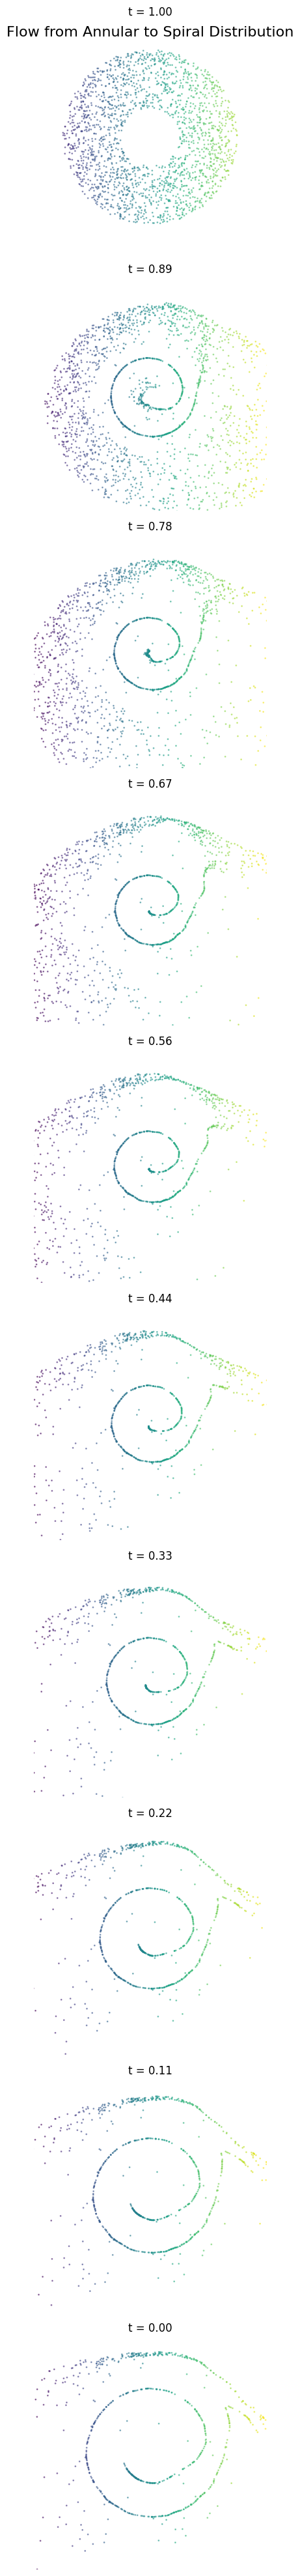

In [8]:
visualize_flow(trained_model, device=device)